In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader, ConcatDataset
import torchvision

stats = ((0.2860,), (0.3530,))

# data from augmentation ablation here
basic_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
train_fms = tt.Compose([tt.RandomCrop(28, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(p=0.5), 
                         tt.RandomVerticalFlip(p=0.5),
                        tt.ToTensor(), 
                        tt.Normalize(*stats,inplace=True)])

batch_size = 1024

train_normal = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=basic_tfms, download=True)
train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=train_fms)

train_dataset = ConcatDataset([train_ds, train_normal])
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

val_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=basic_tfms)
valid_dl = DataLoader(val_dataset, batch_size*2, num_workers=3, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81019837..2.0226629].


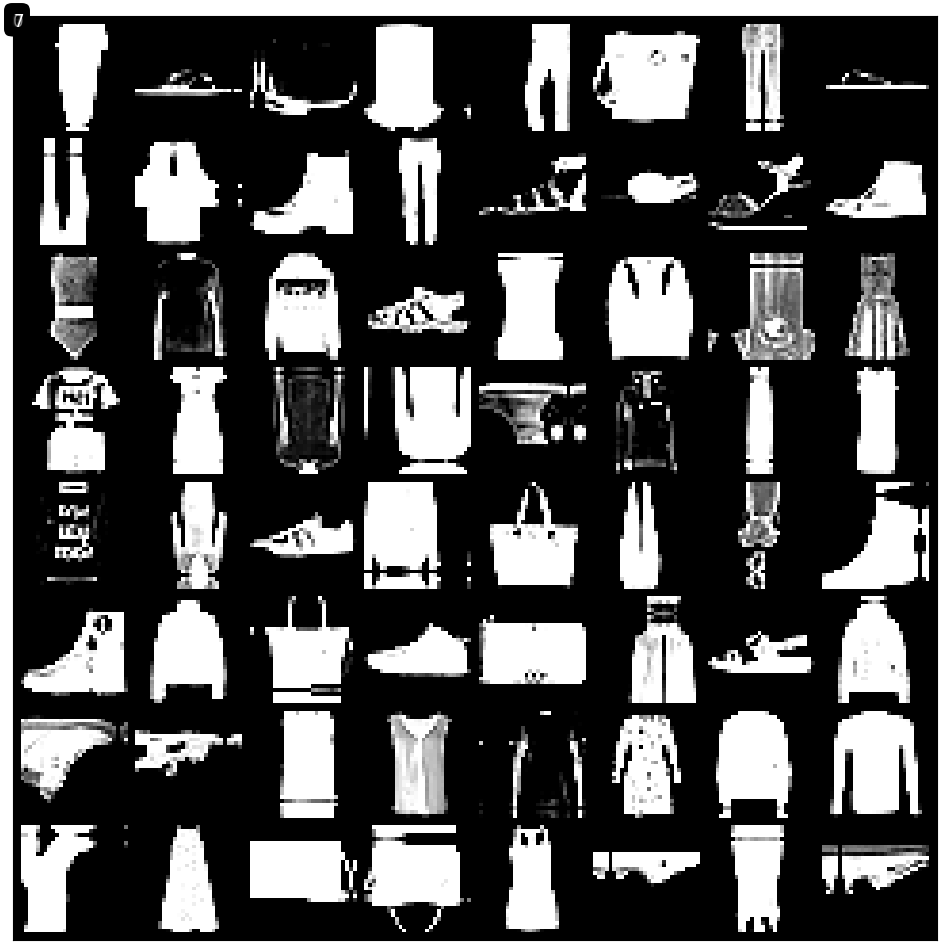

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])

        # Create a grid of images
        grid = make_grid(images[:64], nrow=8)
        ax.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')

        # Add labels above each image
        for i in range(min(len(images), 64)):
            # Calculate the position for each label
            row = i // 8
            col = i % 8
            ax.text(col / 8, (row + 0.5) / 8, str(labels[i].item()), 
                    ha='center', va='center', color='white', fontsize=12, 
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

        break

show_batch(train_dl)

In [4]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    # elif torch.backends.mps.is_available():
    #     return torch.device("mps")
    else:
        return torch.device("cpu")
    
def clear_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()
    # else:
    #     return torch.device("cpu")
    # appers there's nothing to do here
        
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print(f"running on {device}")

running on cuda


In [5]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        
        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU(inplace=True)]
        if pool: 
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [7]:
model = to_device(ResNet9(1, 10), device)
print(model)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [8]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader),
                                                pct_start=0.3)
    
    for epoch in range(epochs):
        # Training Phase 
        #print(f'Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB')
        #print(f'Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB')
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            #print(f'Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB')
            #print(f'Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB')
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3048253059387207, 'val_acc': 0.0997174009680748}]

In [10]:
epochs = 16
max_lr = 0.007
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.AdamW

In [11]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00097, train_loss: 0.5710, val_loss: 0.6023, val_acc: 0.8075
Epoch [1], last_lr: 0.00276, train_loss: 0.3462, val_loss: 0.2665, val_acc: 0.9044
Epoch [2], last_lr: 0.00492, train_loss: 0.2988, val_loss: 0.4271, val_acc: 0.8588
Epoch [3], last_lr: 0.00655, train_loss: 0.2825, val_loss: 0.3600, val_acc: 0.8791
Epoch [4], last_lr: 0.00699, train_loss: 0.2467, val_loss: 0.2645, val_acc: 0.9095
Epoch [5], last_lr: 0.00680, train_loss: 0.2074, val_loss: 0.2364, val_acc: 0.9153
Epoch [6], last_lr: 0.00635, train_loss: 0.1763, val_loss: 0.2390, val_acc: 0.9138
Epoch [7], last_lr: 0.00568, train_loss: 0.1609, val_loss: 0.2041, val_acc: 0.9311
Epoch [8], last_lr: 0.00484, train_loss: 0.1369, val_loss: 0.2217, val_acc: 0.9278
Epoch [9], last_lr: 0.00389, train_loss: 0.1204, val_loss: 0.1957, val_acc: 0.9370
Epoch [10], last_lr: 0.00291, train_loss: 0.1067, val_loss: 0.1835, val_acc: 0.9428
Epoch [11], last_lr: 0.00198, train_loss: 0.0890, val_loss: 0.1937, val_acc: 0.9415
Ep


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


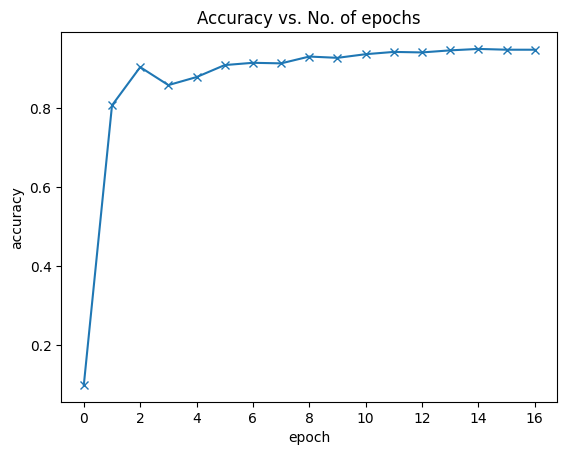

In [12]:
%pip install matplotlib

import matplotlib.pyplot as plt

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

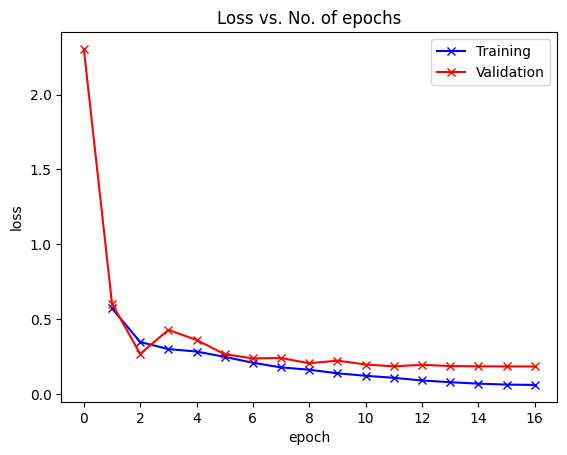

In [13]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)